In [7]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
from pandas.api.types import is_numeric_dtype
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
missing_values

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns

In [ ]:
numerical_columns

In [20]:
for col in numerical_columns:
    if is_numeric_dtype(df[col]):
        df[col].fillna(0.0, inplace=True)

/var/folders/mf/rdhh117n5g95h3nm4hzvkftc0000gn/T/ipykernel_48962/4284273668.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0.0, inplace=True)


In [16]:
for col in categorical_columns:
    df[col].fillna({col: 'NA'}, inplace=True)

In [36]:
from sklearn.model_selection import train_test_split

seed = 1
# 1) hold out 20% for test
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=seed)

# 2) split the remaining 80% into train (75% of 80% = 60% total) and val (25% of 80% = 20% total)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=seed)


# Verify the sizes
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    lead_score
    number_of_courses_viewed
    interaction_count
    annual_income


In [37]:
from sklearn.metrics import roc_auc_score

# List of numerical variables to evaluate
variables = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

# Compute AUC for each variable
for var in variables:
    auc = roc_auc_score(df_train['converted'], df_train[var])
    # If AUC is less than 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(df_train['converted'], -df_train[var])
    auc_scores[var] = auc

# Find the variable with the highest AUC
highest_auc_variable = max(auc_scores, key=auc_scores.get)

auc_scores, highest_auc_variable

({'lead_score': 0.6144993577250176,
  'number_of_courses_viewed': 0.7635680590007088,
  'interaction_count': 0.738270176293409,
  'annual_income': 0.5519578313253012},
 'number_of_courses_viewed')

Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.32
    0.52
    0.72
    0.92


In [46]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

if 'converted' in numerical_columns:
    numerical_columns = numerical_columns.drop('converted')

features = list(categorical_columns) + list(numerical_columns)

# OHE
train_dict = df_train[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(df_val[features].to_dict(orient='records'))

y_train = df_train['converted']
y_val = df_val['converted']

# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict and compute AUC
y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(round(auc, 3))


0.817


Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.145
    0.345
    0.545
    0.745



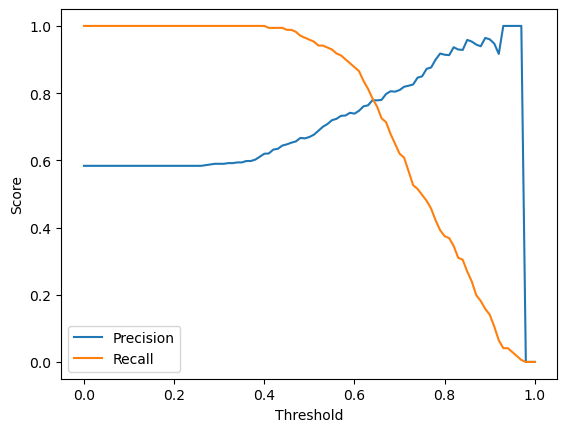

The threshold where precision and recall curves intersect is approximately 0.980


In [48]:
# Question 3: Precision and Recall
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    precisions.append(prec)
    recalls.append(rec)

# Plot
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Find intersection
intersection_threshold = None
min_diff = float('inf')
for i, (p, r) in enumerate(zip(precisions, recalls)):
    diff = abs(p - r)
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresholds[i]

print(f"The threshold where precision and recall curves intersect is approximately {intersection_threshold:.3f}")


Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F 1 = 2 ⋅ P ⋅ R P + R

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.14
    0.34
    0.54
    0.74


In [49]:
# Question 4: F1 score
f1_scores = []
for prec, rec in zip(precisions, recalls):
    if prec + rec > 0:
        f1 = 2 * prec * rec / (prec + rec)
    else:
        f1 = 0
    f1_scores.append(f1)

# Find the threshold with maximal F1
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_scores[max_f1_index]

print(f"The threshold where F1 is maximal is {max_f1_threshold:.2f} with F1 = {max_f1_value:.3f}")


The threshold where F1 is maximal is 0.57 with F1 = 0.812


Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

    0.0001
    0.006
    0.06
    0.36


In [52]:
from sklearn.model_selection import train_test_split, KFold
df_full_train = df_train_val
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    train_dict = df_train_fold[features].to_dict(orient='records')
    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dict)
    X_val_fold = dv_fold.transform(df_val_fold[features].to_dict(orient='records'))
    
    y_train_fold = df_train_fold['converted']
    y_val_fold = df_val_fold['converted']
    
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)
    
    y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
    scores.append(auc_fold)

print('AUC scores:', scores)
print('Standard deviation:', np.std(scores))


AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Standard deviation: 0.03580711942905165


Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.000001, 0.001, 1]
    Initialize KFold with the same parameters as previously
    Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.000001
    0.001
    1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.